# Quickstart


In [2]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai

In [3]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [1]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import END, MessageGraph

model = ChatOpenAI(temperature=0)

graph = MessageGraph()

graph.add_node("oracle", model)
graph.add_edge("oracle", END)

graph.set_entry_point("oracle")

runnable = graph.compile()

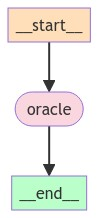

In [2]:
from IPython.display import Image, display

try:
    display(Image(runnable.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [3]:
runnable.invoke(HumanMessage("What is 1 + 1?"))

[HumanMessage(content='What is 1 + 1?', id='125ef1e2-d3ca-48b5-b35d-f592f520c01c'),
 AIMessage(content='1 + 1 equals 2.', response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 15, 'total_tokens': 23}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_a450710239', 'finish_reason': 'stop', 'logprobs': None}, id='run-13375378-12e3-404f-a6b8-dded28584b06-0')]

In [4]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode


@tool
def multiply(first_number: int, second_number: int):
    """Multiplies two numbers together."""
    return first_number * second_number


model = ChatOpenAI(temperature=0)
model_with_tools = model.bind_tools(tools=[multiply])

graph = MessageGraph()

graph.add_node("oracle", model_with_tools)

tool_node = ToolNode([multiply])
graph.add_node("multiply", tool_node)

graph.add_edge("multiply", END)

graph.set_entry_point("oracle")

In [5]:
from typing import Literal


def router(state: list[BaseMessage]) -> Literal["multiply", "__end__"]:
    tool_calls = state[-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "multiply"
    else:
        return END


graph.add_conditional_edges("oracle", router)
runnable = graph.compile()

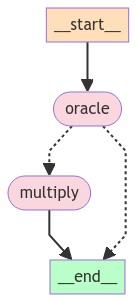

In [6]:
try:
    display(Image(runnable.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [7]:
runnable.invoke(HumanMessage("What is 123 * 456?"))

[HumanMessage(content='What is 123 * 456?', id='7aec9537-0618-4b77-8cbc-527283fc1c19'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_n0CYzEKaI5j9XGyd10wCEesR', 'function': {'arguments': '{"first_number":123,"second_number":456}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 69, 'total_tokens': 88}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_a450710239', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0037ebc2-4418-4498-b81a-9b6854ca69ac-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 123, 'second_number': 456}, 'id': 'call_n0CYzEKaI5j9XGyd10wCEesR'}]),
 ToolMessage(content='56088', name='multiply', id='5a663378-2893-4059-ae7a-947ab0bc1ef4', tool_call_id='call_n0CYzEKaI5j9XGyd10wCEesR')]

In [8]:
runnable.invoke(HumanMessage("What is your name?"))

[HumanMessage(content='What is your name?', id='2913f6c4-8f3e-4273-bfb9-01a6bae7251c'),
 AIMessage(content='My name is Assistant. How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 66, 'total_tokens': 79}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3b956da36b', 'finish_reason': 'stop', 'logprobs': None}, id='run-8b2e0a09-3365-4651-b256-72a9d3a8fb75-0')]